In [1]:
import os
from pathlib import Path
from collections import Counter

import anndata
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pollock
from pollock.models.model import PollockDataset, PollockModel, load_from_directory

In this tutorial we will:
1. load in a PBMC test dataset
2. assign cell labels
3. train a pollock module
4. evaluate model performance
5. retrain module for optimal number of epochs

NOTE: with the exception of adding a layer for raw count data, steps 1 and 2 are largely identical to the [scanpy 3k PBMC clustering tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html)

## 1. load in pbmc data

if this is the first time you are running this notebook, you will need to run this cell to download and store the PBMC dataset

In [2]:
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

read in the 10x scRNA-seq data with scanpy

In [3]:
adata = sc.read_10x_mtx('data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols')
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

Pollock models take raw counts (un-normalized) expression data as input. Here we add a layer to the anndata object with the raw counts so they can be saved for module training later.

In [4]:
adata.layers['raw_counts'] = adata.X.copy()

## 2. assign cell types

In the following cells we do preprocessing recommended by scanpy.

For more details see the [scanpy 3k PBMC clustering tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html)

In [5]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

adata.raw = adata

/Users/erikstorrs/miniconda3/envs/pollock_test_2/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [6]:
adata = adata[:, adata.var.highly_variable]

sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

sc.pp.scale(adata, max_value=10)

In [7]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

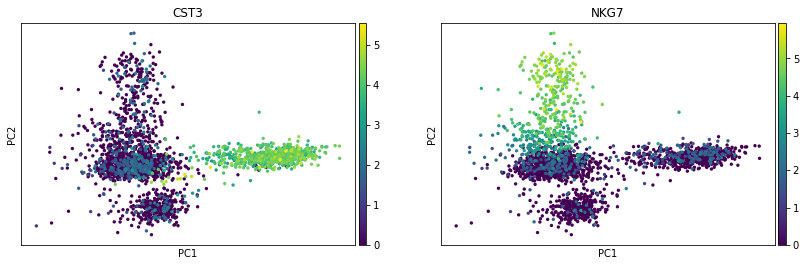

In [10]:
sc.pl.pca(adata, color=['CST3', 'NKG7'])

if you have not installed the leidenalg library yet, you will need to install it by uncommenting and running the following cell

In [14]:
# !conda install -y -c conda-forge leidenalg

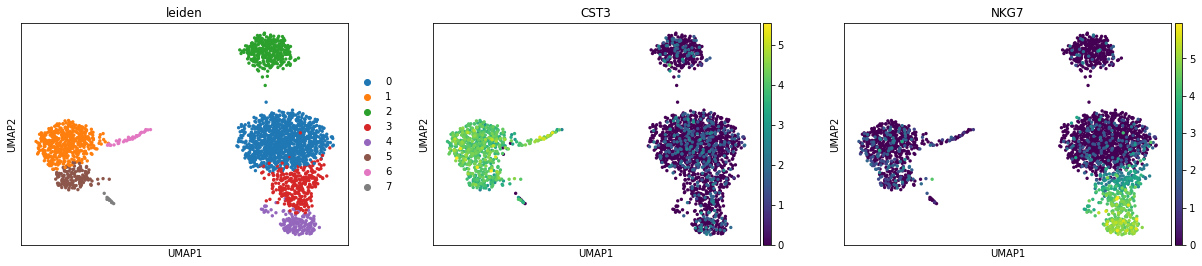

In [35]:
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])


In [28]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

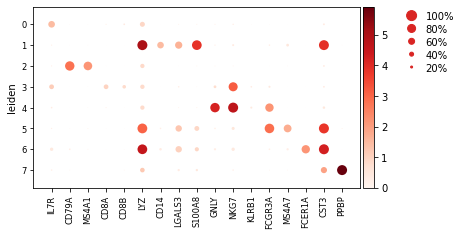

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[5.949999999999999, 0, 0.2, 0.5, 0.25])

In [29]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden')

In [30]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

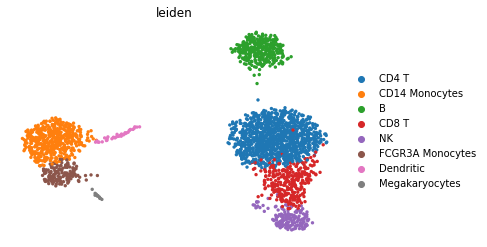

In [33]:
sc.pl.umap(adata, color='leiden', frameon=False)

save the anndata object for later

In [15]:
adata.write_h5ad('data/pbmc.h5ad')

## 3. train pollock module

specify a location to save the trained pollock module

In [16]:
module_save_filepath = 'modules/pbmc'
Path(module_save_filepath).mkdir(parents=True, exist_ok=True)

here we create a new anndata object from our processed anndata object

scanpy expects the raw counts data to be in the X attribute

In [17]:
train_adata = anndata.AnnData(X=adata.layers['raw_counts'],
                             obs=adata.obs,
                             var=adata.var)
train_adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'

take a look at our cell counts

In [18]:
Counter(adata.obs['leiden']).most_common()

[('CD4 T', 1137),
 ('CD14 Monocytes', 486),
 ('B', 342),
 ('CD8 T', 310),
 ('NK', 164),
 ('FCGR3A Monocytes', 150),
 ('Dendritic', 36),
 ('Megakaryocytes', 13)]

initialize PollockDataset
  
  - cell_type_key
    - key in .obs where the cell type label is stored
  - n_per_cell_type
    - number of cells per cell type that should be included in the training dataset. For smaller datasets like this one 200 is usually sufficient. For larger datasets it can be helpful to increase the number of cells to 500-2k range. If you have a particular cell type in your dataset that has a low cell count it is usually a good idea not to increase n_per_cell_type too much. A good rule of thumb is that n_per_cell_type should be no greater than the minimum cell type count * 10
  - oversample
    - if true, then cell types in the training dataset are oversampled so each cell type has n_per_cell_type cells

In [19]:
pds = PollockDataset(train_adata, cell_type_key='leiden', n_per_cell_type=200,
                    oversample=True, dataset_type='training')

2020-06-11 15:52:37,438 normalizing counts for model training
2020-06-11 15:52:37,451 scaling data
2020-06-11 15:52:37,477 creating tf datasets


 create pollock model
    
  - alpha
    - this parameter controls how regularized the BVAE is. .0001 is usually a good value. If you increase alpha the cell embeddings are typically more noisy, but also more generalizable. If you decrease alpha the cell embeddings are typically less noisy, but also less generalizable.
  - latent_dim
    - the shape of the latent dim in the BVAE. In general 25 is a good starting point. This number is analgous to the number of principle components in a traditional pca decomposition.

In [20]:
pm = PollockModel(pds.cell_types, pds.train_adata.shape[1], alpha=.0001, latent_dim=25)

  - epochs
    - the number of epochs the neural net should train for. typically between 25-50, but can vary based on alpha and latent_dim. Usually it's a good idea to train for too many epochs, and then look at the model performance and train again with the optimal number of epochs as we do here in this tutorial

In [21]:
pm.fit(pds, epochs=100)

2020-06-11 15:52:41,672 5 out of the last 14 calls to <function compute_loss at 0x7f88bbccf8c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.
2020-06-11 15:52:42,126 epoch: 1, train loss: 6.878861904144287, val loss: 6.222077369689941
2020-06-11 15:52:42,867 epoch: 2, train loss: 6.164856433868408, val loss: 5.425473690032959
2020-06-11 15:52:43,606 epoch: 3, train loss: 5.642602920532227, val loss: 5.070188045501709
2020-06-11 15:52:44,357 epoch: 4, train loss: 5.0404372215271, val loss: 4.6011552810668945
2020-06-11 15:52:45,113 epoch: 5, train loss: 4.791562080383301, val loss: 4.

2020-06-11 15:53:42,632 epoch: 82, train loss: 3.6010658740997314, val loss: 3.674351215362549
2020-06-11 15:53:43,376 epoch: 83, train loss: 3.6419715881347656, val loss: 3.675342082977295
2020-06-11 15:53:44,103 epoch: 84, train loss: 3.692620038986206, val loss: 3.6819565296173096
2020-06-11 15:53:44,835 epoch: 85, train loss: 3.579296827316284, val loss: 3.680286407470703
2020-06-11 15:53:45,587 epoch: 86, train loss: 3.533780097961426, val loss: 3.673363208770752
2020-06-11 15:53:46,343 epoch: 87, train loss: 3.669182777404785, val loss: 3.674964189529419
2020-06-11 15:53:47,088 epoch: 88, train loss: 3.512019395828247, val loss: 3.674819231033325
2020-06-11 15:53:47,858 epoch: 89, train loss: 3.5973076820373535, val loss: 3.6735763549804688
2020-06-11 15:53:48,593 epoch: 90, train loss: 3.500760078430176, val loss: 3.678971767425537
2020-06-11 15:53:49,334 epoch: 91, train loss: 3.5510599613189697, val loss: 3.6779613494873047
2020-06-11 15:53:50,080 epoch: 92, train loss: 3.5793

save module to the given filepath

In [22]:
pm.save(pds, module_save_filepath)

## 4. module performance

visualize the overlap between groundtruth vs predicted cell types

Text(32.99999999999999, 0.5, 'Groundtruth')

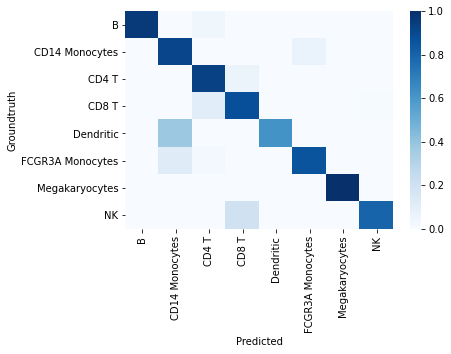

In [23]:
confusion_matrix = pd.DataFrame(data=pm.summary['validation']['confusion_matrix'], columns=pm.class_names,
                  index=pm.class_names)
sns.heatmap(confusion_matrix, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Groundtruth')

plot loss and accuracy for training and validation sets during training

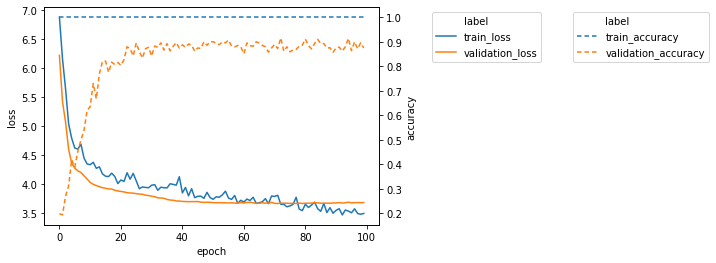

In [24]:
loss, label, epoch = [], [], []
for k in ['train_loss', 'validation_loss']:
    loss += pm.summary['history'][k]
    label += [k] * len(pm.summary['history'][k])
    epoch += list(range(len(pm.summary['history'][k])))
df = pd.DataFrame.from_dict({'label': label, 'loss': loss, 'epoch': epoch})

sns.lineplot(x='epoch', y='loss', data=df, hue='label')
plt.legend(bbox_to_anchor=(1.5, 1))

accuracy, label = [], []
for k in ['train_accuracy', 'validation_accuracy']:
    accuracy += pm.summary['history'][k]
    label += [k] * len(pm.summary['history'][k])
df = pd.DataFrame.from_dict({'label': label, 'accuracy': accuracy, 'epoch': epoch})

ax2 = plt.twinx()
sns.lineplot(x='epoch', y='accuracy', data=df, hue='label', ax=ax2, style='label',
                 dashes=[(3,2), (3,2)])
plt.legend(bbox_to_anchor=(2., 1))

plot validation loss broken down by cell type

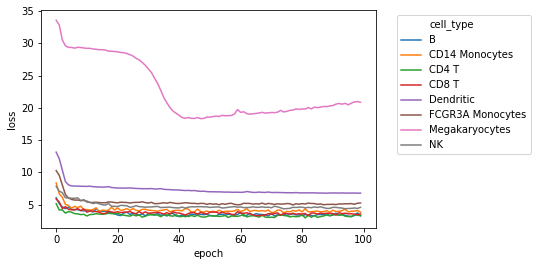

In [25]:
loss, label, epoch = [], [], []
for k in ['cell_type_val_loss']:
    for cell_type, vals in pm.summary['history'][k].items():
        loss += vals
        label += [cell_type] * len(vals)
        epoch += list(range(len(vals)))
    
df = pd.DataFrame.from_dict({
    'cell_type': label,
    'loss': loss,
    'epoch': epoch
})

sns.lineplot(x='epoch', y='loss', data=df, hue='cell_type')
plt.legend(bbox_to_anchor=(1.05, 1))

plot validation accuracy for each cell type during training

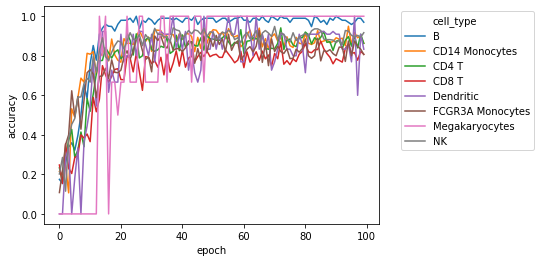

In [26]:
loss, label, epoch = [], [], []
for k in ['cell_type_val_f1']:
    for cell_type, vals in pm.summary['history'][k].items():
        loss += vals
        label += [cell_type] * len(vals)
        epoch += list(range(len(vals)))
    
df = pd.DataFrame.from_dict({
    'cell_type': label,
    'accuracy': loss,
    'epoch': epoch
})

sns.lineplot(x='epoch', y='accuracy', data=df, hue='cell_type')
plt.legend(bbox_to_anchor=(1.05, 1))

## 5. retrain module for optimal number of epochs

from the above plots it apperas that the optimal training time is ~55 epochs for this dataset

In [38]:
pm = PollockModel(pds.cell_types, pds.train_adata.shape[1], alpha=.0001, latent_dim=25)

In [39]:
pm.fit(pds, epochs=55)

2020-06-11 15:55:49,710 5 out of the last 14 calls to <function compute_loss at 0x7f88bbccf8c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.
2020-06-11 15:55:50,161 epoch: 1, train loss: 6.90563440322876, val loss: 6.353094577789307
2020-06-11 15:55:50,922 epoch: 2, train loss: 6.160143852233887, val loss: 5.450121879577637
2020-06-11 15:55:51,669 epoch: 3, train loss: 5.696399688720703, val loss: 5.081519603729248
2020-06-11 15:55:52,416 epoch: 4, train loss: 5.0677809715271, val loss: 4.649921417236328
2020-06-11 15:55:53,185 epoch: 5, train loss: 4.991652488708496, val loss: 4.39

In [40]:
pm.save(pds, module_save_filepath)

Text(32.99999999999999, 0.5, 'Groundtruth')

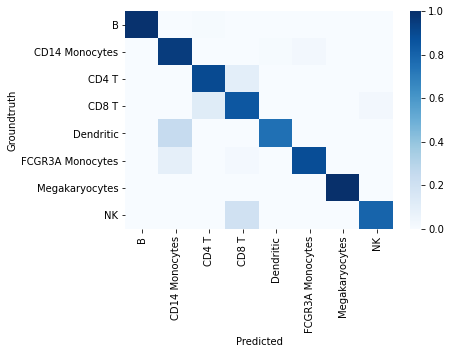

In [41]:
confusion_matrix = pd.DataFrame(data=pm.summary['validation']['confusion_matrix'], columns=pm.class_names,
                  index=pm.class_names)
sns.heatmap(confusion_matrix, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Groundtruth')

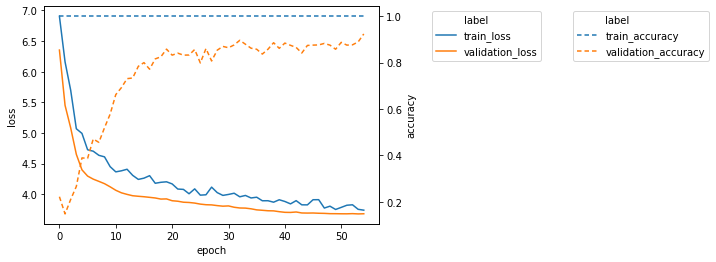

In [42]:
loss, label, epoch = [], [], []
for k in ['train_loss', 'validation_loss']:
    loss += pm.summary['history'][k]
    label += [k] * len(pm.summary['history'][k])
    epoch += list(range(len(pm.summary['history'][k])))
df = pd.DataFrame.from_dict({'label': label, 'loss': loss, 'epoch': epoch})

sns.lineplot(x='epoch', y='loss', data=df, hue='label')
plt.legend(bbox_to_anchor=(1.5, 1))

accuracy, label = [], []
for k in ['train_accuracy', 'validation_accuracy']:
    accuracy += pm.summary['history'][k]
    label += [k] * len(pm.summary['history'][k])
df = pd.DataFrame.from_dict({'label': label, 'accuracy': accuracy, 'epoch': epoch})

ax2 = plt.twinx()
sns.lineplot(x='epoch', y='accuracy', data=df, hue='label', ax=ax2, style='label',
                 dashes=[(3,2), (3,2)])
plt.legend(bbox_to_anchor=(2., 1))

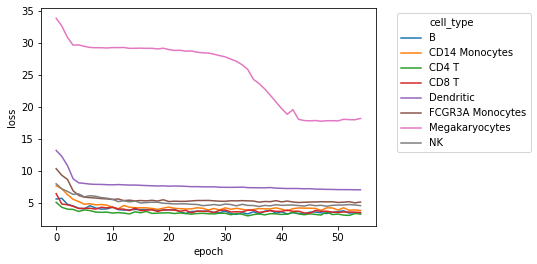

In [43]:
loss, label, epoch = [], [], []
for k in ['cell_type_val_loss']:
    for cell_type, vals in pm.summary['history'][k].items():
        loss += vals
        label += [cell_type] * len(vals)
        epoch += list(range(len(vals)))
    
df = pd.DataFrame.from_dict({
    'cell_type': label,
    'loss': loss,
    'epoch': epoch
})

sns.lineplot(x='epoch', y='loss', data=df, hue='cell_type')
plt.legend(bbox_to_anchor=(1.05, 1))

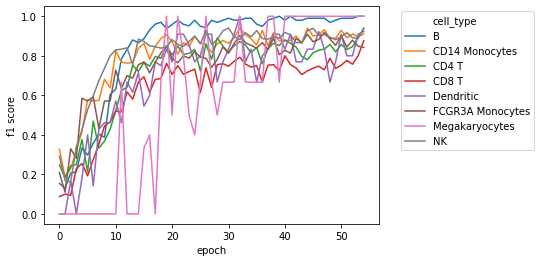

In [49]:
f1, label, epoch = [], [], []
for k in ['cell_type_val_f1']:
    for cell_type, vals in pm.summary['history'][k].items():
        f1 += vals
        label += [cell_type] * len(vals)
        epoch += list(range(len(vals)))
    
df = pd.DataFrame.from_dict({
    'cell_type': label,
    'f1 score': f1,
    'epoch': epoch
})

sns.lineplot(x='epoch', y='f1 score', data=df, hue='cell_type')
plt.legend(bbox_to_anchor=(1.05, 1))

In [45]:
train_adata = anndata.AnnData(X=adata.layers['raw_counts'],
                             obs=adata.obs,
                             var=adata.var)
loaded_pds, loaded_pm = load_from_directory(train_adata, module_save_filepath)

2020-06-11 15:56:32,896 normalizing counts for prediction
2020-06-11 15:56:32,897 filtering for genes in training set
2020-06-11 15:56:32,899 0 genes in training set are missing from prediction set
/miniconda/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-06-11 15:56:32,934 scaling data


In [46]:
labels, probs, cell_type_probs = loaded_pm.predict_pollock_dataset(loaded_pds, labels=True, )
labels[:5], probs[:5]

(('CD4 T', 'B', 'CD4 T', 'CD14 Monocytes', 'CD8 T'),
 (0.95, 0.88, 0.98, 0.82, 0.4))

In [47]:
adata.obs['annotated_cell_type'] = adata.obs['leiden'].to_list()
adata.obs['predicted_cell_type'] = list(labels)
adata.obs['predicted_probablility'] = list(probs)

... storing 'annotated_cell_type' as categorical
... storing 'predicted_cell_type' as categorical


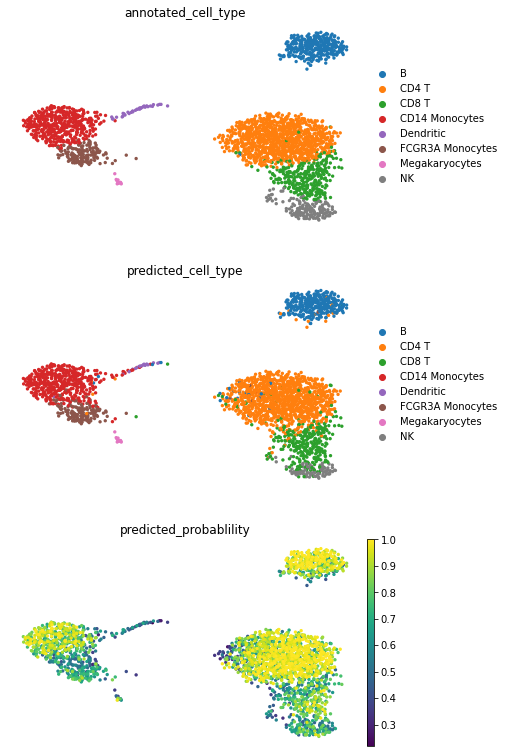

In [48]:
sc.pl.umap(adata, color=['annotated_cell_type', 'predicted_cell_type', 'predicted_probablility'],
          frameon=False, ncols=1)